# Regressione polinomiale su un dataset sintetico multivariato

## Generazione del dataset sintetico

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Imposta alcuni parametri per la visualizzazione degli array.
np.set_printoptions(threshold=55, edgeitems=10, suppress=True)

# Abilita la visualizzazione dei grafici all'interno del notebook.
%matplotlib inline

# Specifica la dimensione del dataset da generare.
n = 10

# Aggiorna il numero di punti generati.
DATASET_SIZE = n * n

# Definisce la funzione sconosciuta da approssimare.
def unknown_function(x, y):
    return -x ** 2 - y ** 2 * 3 * x * y ** 2

# Genera il dataset sintetico.
x, y = np.meshgrid(np.arange(n), np.arange(n))
xs = x.flatten()
ys = y.flatten()
zs = unknown_function(xs, ys)
zs = zs + 5000 * np.random.randn(100)
features = np.hstack([xs.reshape(DATASET_SIZE, 1), ys.reshape(DATASET_SIZE, 1)])

# Genera i punti mediante i quali disegnare i grafici dei polinomi determinati.
sx = sy = np.arange(0, 10, 0.05)
sX, sY = np.meshgrid(sx, sy)
space = np.hstack([np.ravel(sX)[:, np.newaxis], np.ravel(sY)[:, np.newaxis]])

## Raccolta di informazioni sul dataset generato

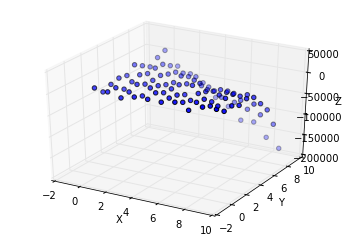

In [16]:
# Disegna il grafico di dispersione del dataset.
fig = plt.figure()
ax = fig.add_subplot("111", projection="3d")
ax.scatter(xs, ys, zs)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

## Regressione polinomiale multivariata

Si definisce, innanzi tutto, il grado del polinomio di migliore approssimazione di esempio da costruire.

In [17]:
# Specifica il grado per la costruzione del polinomio di esempio.
degree = 2

### Metodo 1: regressione polinomiale mediante Scikit-learn

#### Regressione polinomiale mediante la costruzione di feature polinomiali

Si implementa, di seguito, la regressione polinomiale mediante una regressione effettuata considerando feature polinomiali generate a partire dalle feature iniziali. Ciò è equivalente ad effettuare la regressione polinomiale considerando una matrice di Vandermonde costituita da feature polinomiali.

Coefficienti determinati:
[-22669.23505205   3930.22126701  16053.31863087     20.25282654
  -1921.92913261  -1753.54752422]


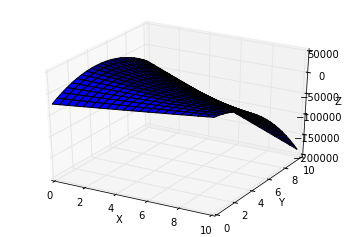

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Non si considera l'intercetta perché essa è implicitamente considerata,
# dato che la classe PolynomialFeatures costruisce anche una colonna di 1.
best_estimator = make_pipeline(PolynomialFeatures(2), LinearRegression(fit_intercept=False))
best_estimator.fit(features[:, :2], zs)

print("Coefficienti determinati:\n{0}".format(best_estimator.steps[-1][1].coef_))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
predictions = best_estimator.predict(space)
sZ = predictions.reshape(sX.shape)
ax.plot_surface(sX, sY, sZ)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

#### Regressione polinomiale mediante Support Vector Regression con kernel polinomiale

Si implementa, di seguito, la regressione polinomiale effettuando Support Vector Regression con un kernel polinomiale. La Support Vector Regression è una estensione delle Support Vector Machines per effettuare regressione anziché classificazione. Le Support Vector Machine effettuano classificazione massimizzando il margine tra l'iperpiano di separazione e i cosiddetti vettori di supporto. Tale massimizzazione, suggerita dalla VC dimension della Teoria dell'Apprendimento Computazionale, è vincolata al dover separare linearmente il dataset. I kernel permettono di trasformare il dataset a disposizione, solitamente non linearmente separabile, in un dataset di dimensioni superiori avente separabilità lineare. La regressione è effettuata adottando un procedimento analogo a quello descritto.

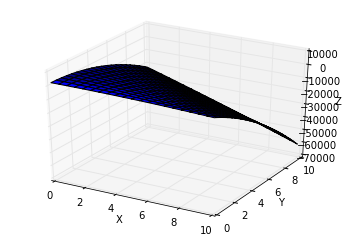

In [19]:
from sklearn.svm import SVR

svr_poly = SVR(kernel='poly', degree=2)
svr_model = svr_poly.fit(features[:, :2], zs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
predictions = svr_model.predict(space)
sZ = predictions.reshape(sX.shape)
ax.plot_surface(sX, sY, sZ)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

### Metodo 2: implementazione ed esecuzione mediante NumPy

Si definiscono, di seguito, alcune costanti e funzioni che verranno utilizzate per la costruzione del polinomio di migliore approssimazione.

In [20]:
def polynomial(coefficients):
    def function(x, y):
        result = 0
        j = 0
        for xd in range(0, degree+1):
            for yd in range(0, degree+1 - xd):
                result = result + coefficients[j] * x ** xd * y ** yd
                j += 1
        return result
    return function

A = []

for i in range(DATASET_SIZE):
    A.append([])
    for xd in range(degree+1):
        for yd in range(degree+1 - xd):
            A[i].append((xs[i] ** xd) * (ys[i] ** yd))

A = np.array(A)

#### Regressione polinomiale mediante la risoluzione del sistema delle equazioni normali

Si implementa, di seguito, la regressione polinomiale mediante la risoluzione del sistema delle equazioni normali.

Coefficienti determinati:
[-22669.23505205  16053.31863087  -1753.54752422   3930.22126701
  -1921.92913261     20.25282654]


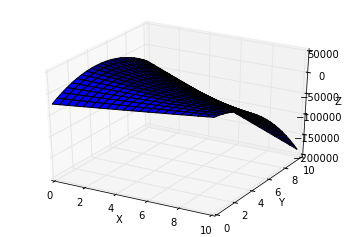

In [21]:
np_coefficients = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, zs))
print("Coefficienti determinati:\n{0}".format(np_coefficients))
np_best_estimator = polynomial(np_coefficients)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
predictions = np.array([np_best_estimator(sx, sy) for sx, sy in zip(np.ravel(sX), np.ravel(sY))])
sZ = predictions.reshape(sX.shape)
ax.plot_surface(sX, sY, sZ)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

#### Regressione polinomiale mediante la risoluzione del problema dei minimi quadrati

Si implementa, di seguito, la regressione polinomiale mediante la risoluzione del problema dei minimi quadrati.

Coefficienti determinati:
[-22669.23505205  16053.31863087  -1753.54752422   3930.22126701
  -1921.92913261     20.25282654]


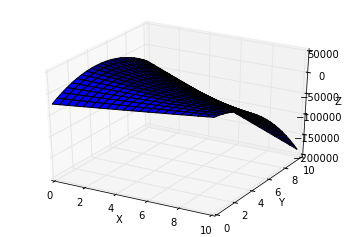

In [22]:
np_coefficients = np.linalg.lstsq(A, zs)[0]
print("Coefficienti determinati:\n{0}".format(np_coefficients))
np_best_estimator = polynomial(np_coefficients)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
predictions = np.array([np_best_estimator(sx, sy) for sx, sy in zip(np.ravel(sX), np.ravel(sY))])
sZ = predictions.reshape(sX.shape)
ax.plot_surface(sX, sY, sZ)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

#### Regressione polinomiale mediante la decomposizione QR

Si implementa, di seguito, la regressione polinomiale mediante la decomposizione QR.

Tale metodo di risoluzione è solitamente preferito rispetto alla risoluzione del sistema delle equazioni normali perché esso permette di ottenere una migliore stabilità numerica al crescere della dimensione del problema mantenendo un costo accettabile in termini di prestazioni.

Coefficienti determinati:
[-22669.23505205  16053.31863087  -1753.54752422   3930.22126701
  -1921.92913261     20.25282654]


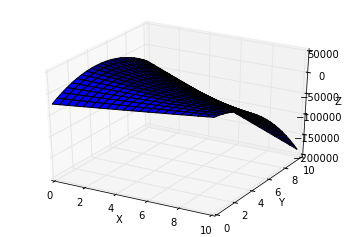

In [23]:
# Effettua la fattorizzazione QR della matrice di Vandermonde.
Q, R = np.linalg.qr(A)

# Effettua il prodotto tra Q.T e y.
Qb = np.dot(Q.T, zs)

# Risolve il sistema Rx = Qb.
np_coefficients = np.linalg.solve(R, Qb)
print("Coefficienti determinati:\n{0}".format(np_coefficients))
np_best_estimator = polynomial(np_coefficients)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
predictions = np.array([np_best_estimator(sx, sy) for sx, sy in zip(np.ravel(sX), np.ravel(sY))])
sZ = predictions.reshape(sX.shape)
ax.plot_surface(sX, sY, sZ)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

#### Regressione polinomiale mediante la decomposizione ai valori singolari

Si implementa, di seguito, la regressione polinomiale mediante la decomposizione ai valori singolari.

Coefficienti determinati:
[-22669.23505205  16053.31863087  -1753.54752422   3930.22126701
  -1921.92913261     20.25282654]


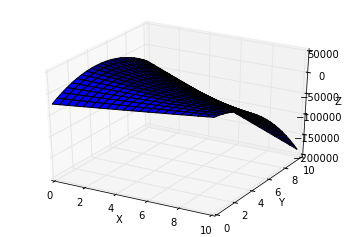

In [24]:
# Effettua la fattorizzazione SVD della matrice di Vandermonde.
U, s, V = np.linalg.svd(A)

np_coefficients = np.zeros(A.shape[1])

for i in range(len(s)):
    np_coefficients += ((U[:, i].T).dot(zs) / s[i]) * V.T[:, i]

print("Coefficienti determinati:\n{0}".format(np_coefficients))

np_best_estimator = polynomial(np_coefficients)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
predictions = np.array([np_best_estimator(sx, sy) for sx, sy in zip(np.ravel(sX), np.ravel(sY))])
sZ = predictions.reshape(sX.shape)
ax.plot_surface(sX, sY, sZ)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

## Validazione della regressione polinomiale multivariata

N.B.: si considera, per la validazione, il modello di regressione polinomiale precedentemente ottenuto con Scikit-learn.

Si mostra, di seguito, una curva di validazione costituita da una rappresentazione dell'errore, misurato mediante RMSE, del modello al variare del grado del polinomio di migliore approssimazione. L'errore è stato misurato sia sul training set sia sul test set in modo da studiare bias e varianza del modello.

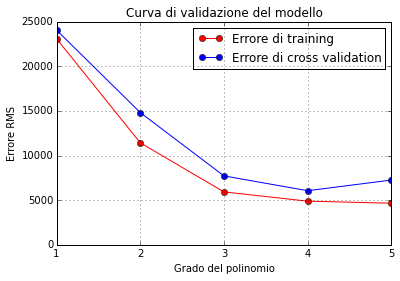

In [30]:
from sklearn.learning_curve import validation_curve

degrees = range(1, 6)

def rms_error(model, x, y):
    y_pred = model.predict(x)
    return np.sqrt(np.mean((y - y_pred) ** 2))

val_train, val_test = validation_curve(best_estimator, features[:, :2], zs,
                                       'polynomialfeatures__degree', degrees,
                                       cv=10, scoring=rms_error)

train_scores_mean = np.mean(val_train, axis=1)
test_scores_mean = np.mean(val_test, axis=1)
plt.figure()
plt.grid()
plt.title("Curva di validazione del modello")
plt.plot(degrees, train_scores_mean, "o-", color="r", label="Errore di training")
plt.plot(degrees, test_scores_mean, "o-", color="b", label="Errore di cross validation")
plt.xlabel('Grado del polinomio')
plt.ylabel('Errore RMS')
plt.xticks(list(degrees))
plt.legend()
plt.show()

## Regolarizzazione mediante norma L1 e L2

In caso di overfitting della regressione polinomiale, si può effettuare regolarizzazione con Scikit-learn nelle seguenti modalità:

- Regolarizzazione mediante penalizzazione L1 (Lasso regression)
    - Riferimento:
    http://scikit-learn.org/stable/modules/linear_model.html#lasso
    
- Regolarizzazione mediante penalizzazione L2 (Ridge regression)
    - Riferimento:
    http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression

- Combinazione della regolarizzazione L1 e L2 (Elastic Net)
    - Riferimento:
    http://scikit-learn.org/stable/modules/linear_model.html#elastic-net

Per ulteriori informazioni:
- G. James, D. Witten, T. Hastie, R. Tibshirani - An introduction to Statistical Learning
    - Reperibile all'indirizzo: http://www-bcf.usc.edu/~gareth/ISL/
- T. Hastie, R. Tibshirani, J. Friedman - Elements of Statistical Learning
    - Reperibile all'indirizzo: http://statweb.stanford.edu/~tibs/ElemStatLearn/